![Galileo](https://github.com/RainieroPV/Ciencia-de-Datos-en-Python/blob/main/images/GalileoLogo.PNG?raw=true  "Galileo")
> #### Ciencia de Datos en Python, Seccion V
>>  Rainiero Jose Parrales Vargas  
>>  20032022.

# Proyecto Final
___

+ Cargar las librerias necesarias

In [2]:
import pandas  as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model
import math

## Slice
1. Lo maneje como pandas ya que hay funciones rapidas para el calculo
2. Calculo el slide desde el constructor

## Mi objeto ModeloLineal el cual tendra lo necesario para cada etapa del proyecto

In [3]:
class ModelosLineales(): 
    def __init__(self, file, columnName, division):
        DataCompleta = np.load(file)
        self.columnName = columnName
        self.dfPandas = pd.DataFrame(DataCompleta, columns=columnName) # usando Pandas
        particion = pd.DataFrame(DataCompleta, columns=columnName)
        filas = int(len(particion)*(80/100)) # calculo el 80%
        self.Modelo = particion[:filas] # Hago la particion del modelo
        self.Validacion = particion[filas:] # Hago la particion de la validacion
    
    def valoresEstadisticos(self):
        calculoModelo = self.Modelo.describe(include = 'all') # con la funcion describe puedo calculas las variables solicitadas
        # filtro lo que quiero
        calculoModelo = calculoModelo.loc[['mean','min','max','std'],self.columnName]
        calculoModelo.loc['rango']= calculoModelo.loc['max'] - calculoModelo.loc['min'] #calculo de punto a punto
        return calculoModelo

    def graficarDatos(self):
        nombres  = list (self.dfPandas.columns) # nombre de columnas
        filas = (len(nombres))//2
        sns.set(style="darkgrid")
        fig, axs = plt.subplots(filas, 2, figsize=(22, filas*10))
        colors = np.array(["skyblue","olive","gold","teal"]) # Colores a usar
        f = 0 # contador de fila donde pondre la imagen
        c = 0 # donde pondre la imagen
        Colores = 0
        for pos1, axis1 in enumerate(nombres):
            sns.histplot(data=self.Modelo, x=axis1, kde=True, color=colors[Colores], ax=axs[f, c])
            c = c+1
            Colores = Colores + 1
            if (c > 1):
                c = 0
                f = f + 1
            if (Colores > 3 ):
                Colores = 0
        plt.show()
        
    def graficarCorrelaciones (self):
        nombres  = list (self.dfPandas.columns) # nombre de columnas
        filas = (sum(range(len(nombres))))//3  # cuantas filas tendremos
        colors = np.array(["skyblue","olive","gold","orange","brown","magenta"]) # Colores a usar
        i = 1 # contador de donde pondre la grafica
        plt.figure(figsize=(22,filas*8)) # Tamanio de la grafica
        for pos1, axis1 in enumerate(nombres):   # tomar la primera columna
            for pos2, axis2 in  enumerate(nombres[pos1+1:]): # tomar la columna que sigue al punto anterior
                plt.subplot(5,3,i)
                df = self.dfPandas[[axis2,axis1]].dropna()  # Quitar los nan
                plt.scatter(df.iloc[:,0], df.iloc[:,1], color=colors[pos1]) #scatter plot
                a, b = np.polyfit(df.iloc[:,0], df.iloc[:,1], 1) #determinar los parametros de regresion lineal
                x = df.iloc[:,0]
                plt.plot(x, a*x + b, color = "black") #Regresion Lineal con scatter-plot
                correlacion = pearsonr(x = df.iloc[:,0], y =  df.iloc[:,1])
                plt.xlabel(axis2) # en X
                plt.ylabel(axis1) # en Y
                title = str('{0:.10f}'.format(a))+"*X+"+str(round(b, 9))+"\n Corr = "+str(round(correlacion[0], 5))
                plt.title(title)
                print("Correlacion entre =",axis1, " y ",axis2,"=",round(correlacion[0], 7)) 
                i = i + 1
        plt.show  
    
    def regresionLinealIterado (self, nombre_x, nombre_y, epochs, imprimir_error, learning_rate, inicialB0, inicialB1):
    # Valores iniciales
        b0 = inicialB0
        b1 = inicialB1
        x = self.Modelo[nombre_x]
        y = self.Modelo[nombre_y]
        # Resultados
        Resultado = pd.DataFrame(columns=["Errores","Coeficiente","Interseccion"])

        # Matriz X , con vector 1
        matrizInicial = pd.DataFrame(x)
        matrizInicial['uno'] = 1 

        for i in range(0,epochs+1):
            # producto punto
            prouctoPunto = matrizInicial.dot([b0,b1])
            # calculo del error
            error = (((y - prouctoPunto)**2).sum())/(2*y.size)
            # calculo del gradiente para b0
            gradiente = (matrizInicial.multiply((prouctoPunto - y),axis="index").sum())/(y.size)
            b0 = b0 - learning_rate*gradiente[0]
            b1 = b1 - learning_rate*gradiente[1]
            new_row = {'Errores':error, 'Coeficiente':b0 , 'Interseccion':b1}
            Resultado=Resultado.append(new_row,ignore_index=True)
            if i % imprimir_error == 0:
                print("Iteracion: ", i," --> Error",error)
        return Resultado
    
    def diagramar_modelo_iteracion (self, Datos_y, Datos_x, n, aprendizaje):
        y = self.Modelo[Datos_y].values
        x = self.Modelo[Datos_x].values
        colors = np.array(["black","olive","gold","orange","brown","magenta"]) # Colores a usar
        i = 1 # contador iteraciones
        colorint = 0
        plt.figure(figsize=(10,10)) # Tamanio de la grafica
        plt.scatter(x, y, color="blue") #scatter plot
        plt.xlabel(Datos_x) # en X
        plt.ylabel(Datos_y) # en Y
        plt.title("Grafico de Modelo Iterativo")
        for index, row in aprendizaje.iterrows():   # tomar la primera columna
            if i % n == 0:
                plt.plot(x, row['Coeficiente']*x + row['Interseccion'], color=colors[colorint]) #Regresion Lineal de nuestro aprendizaje
                colorint = colorint + 1
                if (colorint >= len(colors)):
                    colorint = 0
            i = i + 1

    @staticmethod
    def graficaErrores (errores ,iteration):
        plt.figure(figsize=(10,10))
        plt.scatter(iteration, errores ,color = "magenta")
        plt.xlabel('Iteracion')
        plt.ylabel('Error')
        plt.title('Grafico de Errores')
        plt.show()
        
    @staticmethod
    def comparativa_modelos (modeloIterativo , modeloScikitLearn , datos):
        coedSci = modeloScikitLearn.coef_
        interSci = modeloScikitLearn.intercept_
        coeIterado = modeloIterativo.iloc[-1]['Coeficiente']
        interIterado = modeloIterativo.iloc[-1]['Interseccion']
        coePromedio = (coedSci + coeIterado)/2
        interPromedio = (interSci+interIterado) / 2
        
        print('Coeficiente SKILEARN:', coedSci)
        print('Interseccion SKILEARN:', interSci)
        print('Coeficiente Iterativo:', coeIterado)
        print('Interseccion Iterativo:', interIterado)
        print('Coeficiente Promediado:', coePromedio)
        print('Interseccion Iterativo:', interPromedio)
        # Modelo Iterativo
        predicIterativo = datos*coeIterado + interIterado
        datosIterativo = np.concatenate( predicIterativo, axis=None)
        
        # Modelo ScikitLearn
        predicSci = modeloScikitLearn.predict(datos)
        datosSci = np.concatenate( predicSci, axis=None)
        
        # Modelo Promediado
        predicPromediado = datos*coePromedio + interPromedio
        datosPromediado = np.concatenate( predicPromediado, axis=None)

        df = pd.DataFrame()
        df['Itrativo']  = datosIterativo
        df['ScikitLearn']  = datosSci
        df['Promediado']  = datosPromediado
        
        return df
        
    @staticmethod
    def comparativa_Errores (Modelos, Y_datos):
        #print(Y_datos)
        Evaluar = Modelos['ScikitLearn'].values
        datos = np.reshape(Evaluar,(-1,1))
        ScikitLMSE = (((Y_datos-datos)**2)/(len(Y_datos))).sum()
        Evaluar = Modelos['Itrativo'].values
        datos = np.reshape(Evaluar,(-1,1))
        IterativoMSE = (((Y_datos-datos)**2)/(len(Y_datos))).sum()
        Evaluar = Modelos['Promediado'].values
        datos = np.reshape(Evaluar,(-1,1))
        PromedioMSE = (((Y_datos-datos)**2)/(len(Y_datos))).sum()
        df = pd.DataFrame({'MSE': [ScikitLMSE,IterativoMSE,PromedioMSE]},index=['ScikitLearn', 'Itrativo', 'Promediado'])
        df = df.sort_values(by=['MSE'])
        print(df)
        
        nombres  = list (df.index) # nombre de columnas
        y_pos = np.arange(len(nombres))
        plt.figure(figsize=(10,10))
        plt.bar(y_pos, df.iloc[:,0])
        plt.title('Comparacion de errores')
        plt.ylabel('MSE')
        # Create names
        plt.xticks(y_pos, nombres)
        plt.show()


1. Cargar el archivo  - Este lo maneje con una subcarpeta de donde esta el proyeto
2. Las columnas que tienen mis datos
3. Mando a construir mi clase de analisis Lineal

In [4]:
path = './proyecto_data/proyecto_training_data.npy' # path del archivo 
Columnas = ['SalePrice','OverallQual','1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage'] # pongo titulos a las columnas
ModeloUnaVariable = ModelosLineales(path,Columnas,80)

4. Mando a pedir los datos estadisticos de los cargos

 ## Analisis exploratorio de datos
+ Para cada variable en el dataset calcular:
+ Media
+ Valor maximo
+ Valor minimo
+ Rango
+ Desviacion estandar.

In [5]:
print ("=---------------------------------------------------=")
print ("Valores Estadisticos de nuestras variables:")
print ("=---------------------------------------------------=")
print(ModeloUnaVariable.valoresEstadisticos())

=---------------------------------------------------=
Valores Estadisticos de nuestras variables:
=---------------------------------------------------=
           SalePrice  OverallQual     1stFlrSF  TotRmsAbvGrd    YearBuilt  \
mean   180590.277397     6.101027  1156.323630      6.485445  1971.451199   
min     34900.000000     1.000000   334.000000      2.000000  1875.000000   
max    755000.000000    10.000000  3228.000000     14.000000  2010.000000   
std     78815.697902     1.378025   373.780374      1.609141    29.951707   
rango  720100.000000     9.000000  2894.000000     12.000000   135.000000   

       LotFrontage  
mean     69.946985  
min      21.000000  
max     313.000000  
std      23.478161  
rango   292.000000  


## Para cada variable en el dataset usar seaborn
+ para graficar un histograma de la variable.

=---------------------------------------------------=
Graficas las variables:
=---------------------------------------------------=


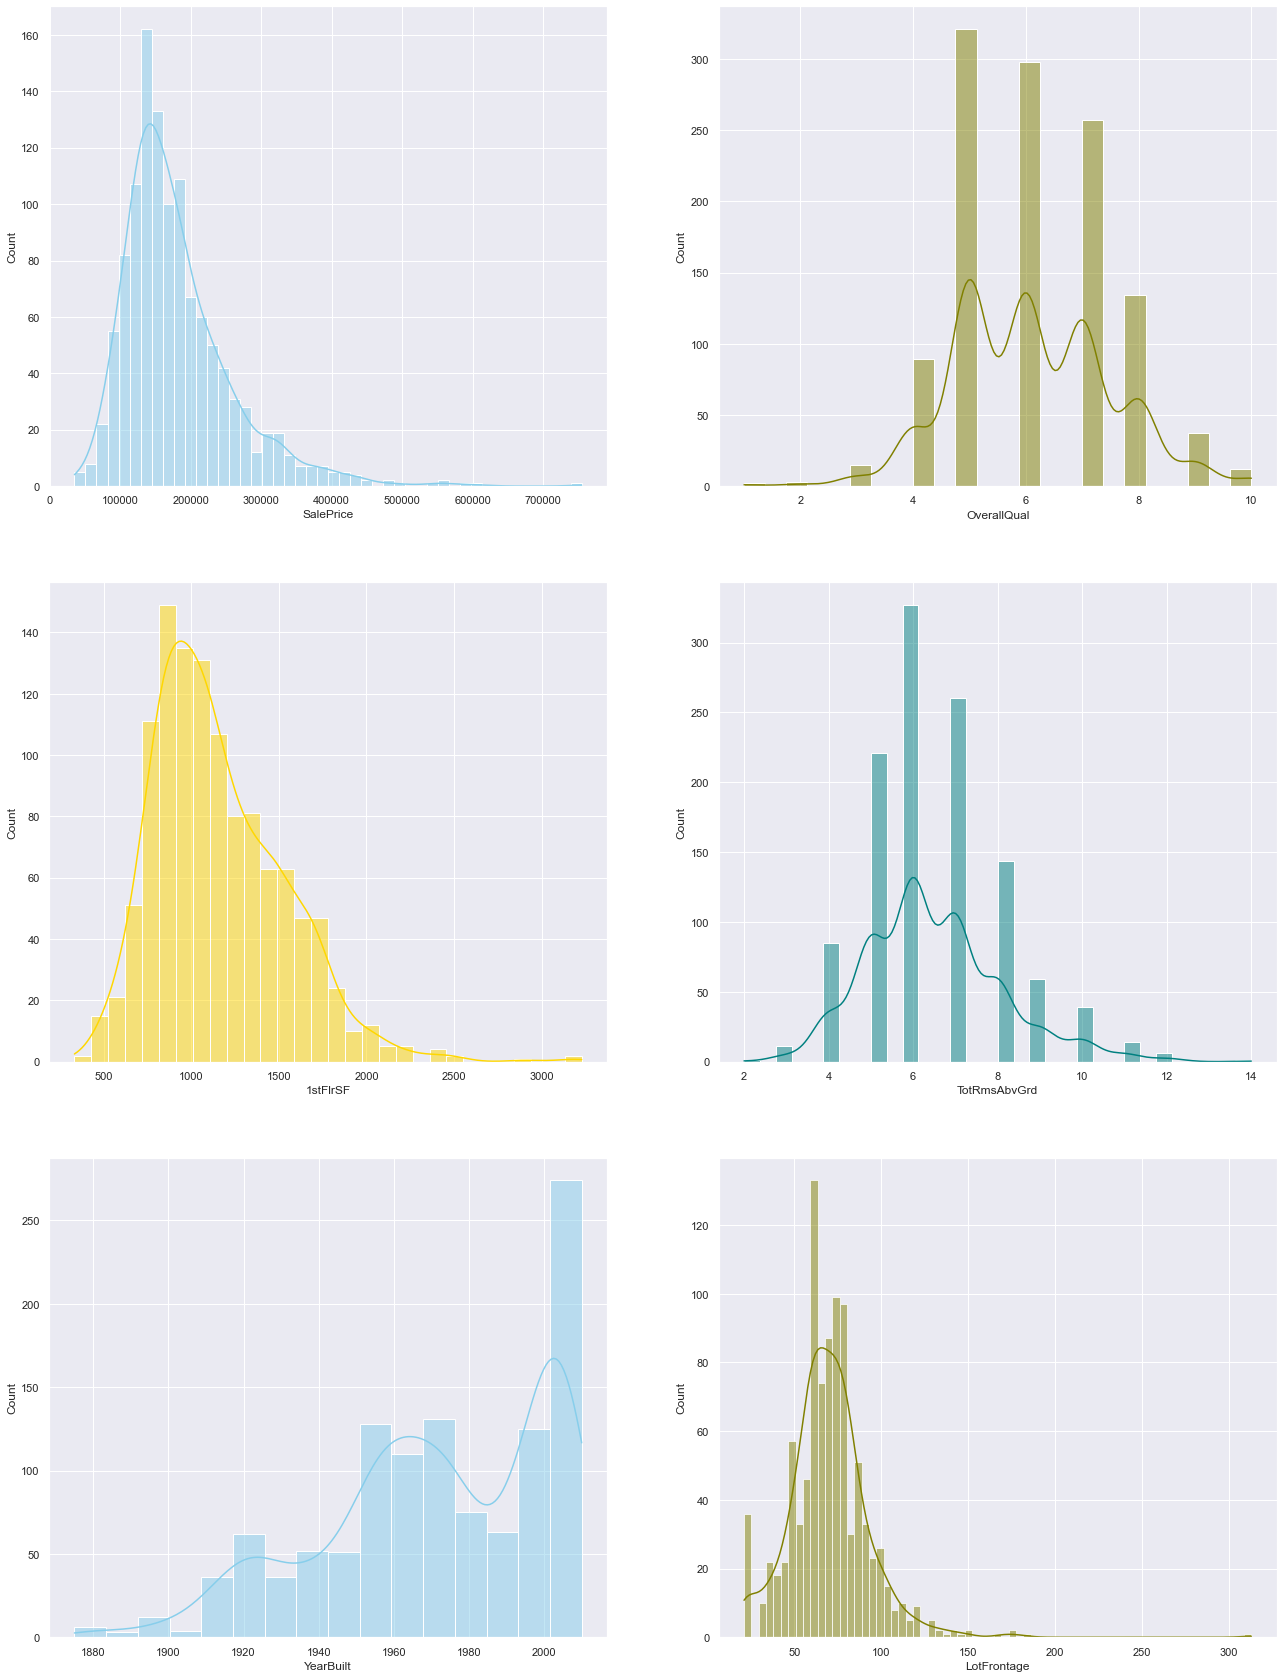

In [6]:
print ("=---------------------------------------------------=")
print ("Graficas las variables:")
print ("=---------------------------------------------------=")
ModeloUnaVariable.graficarDatos()

=---------------------------------------------------=
Graficas las Correlaciones:
=---------------------------------------------------=
Correlacion entre = SalePrice  y  OverallQual = 0.7909816
Correlacion entre = SalePrice  y  1stFlrSF = 0.6058522
Correlacion entre = SalePrice  y  TotRmsAbvGrd = 0.5337232
Correlacion entre = SalePrice  y  YearBuilt = 0.5228973
Correlacion entre = SalePrice  y  LotFrontage = 0.3517991
Correlacion entre = OverallQual  y  1stFlrSF = 0.4762238
Correlacion entre = OverallQual  y  TotRmsAbvGrd = 0.4274523
Correlacion entre = OverallQual  y  YearBuilt = 0.5723228
Correlacion entre = OverallQual  y  LotFrontage = 0.2516458
Correlacion entre = 1stFlrSF  y  TotRmsAbvGrd = 0.409516
Correlacion entre = 1stFlrSF  y  YearBuilt = 0.2819859
Correlacion entre = 1stFlrSF  y  LotFrontage = 0.457181
Correlacion entre = TotRmsAbvGrd  y  YearBuilt = 0.0955891
Correlacion entre = TotRmsAbvGrd  y  LotFrontage = 0.3520959
Correlacion entre = YearBuilt  y  LotFrontage = 0.1233

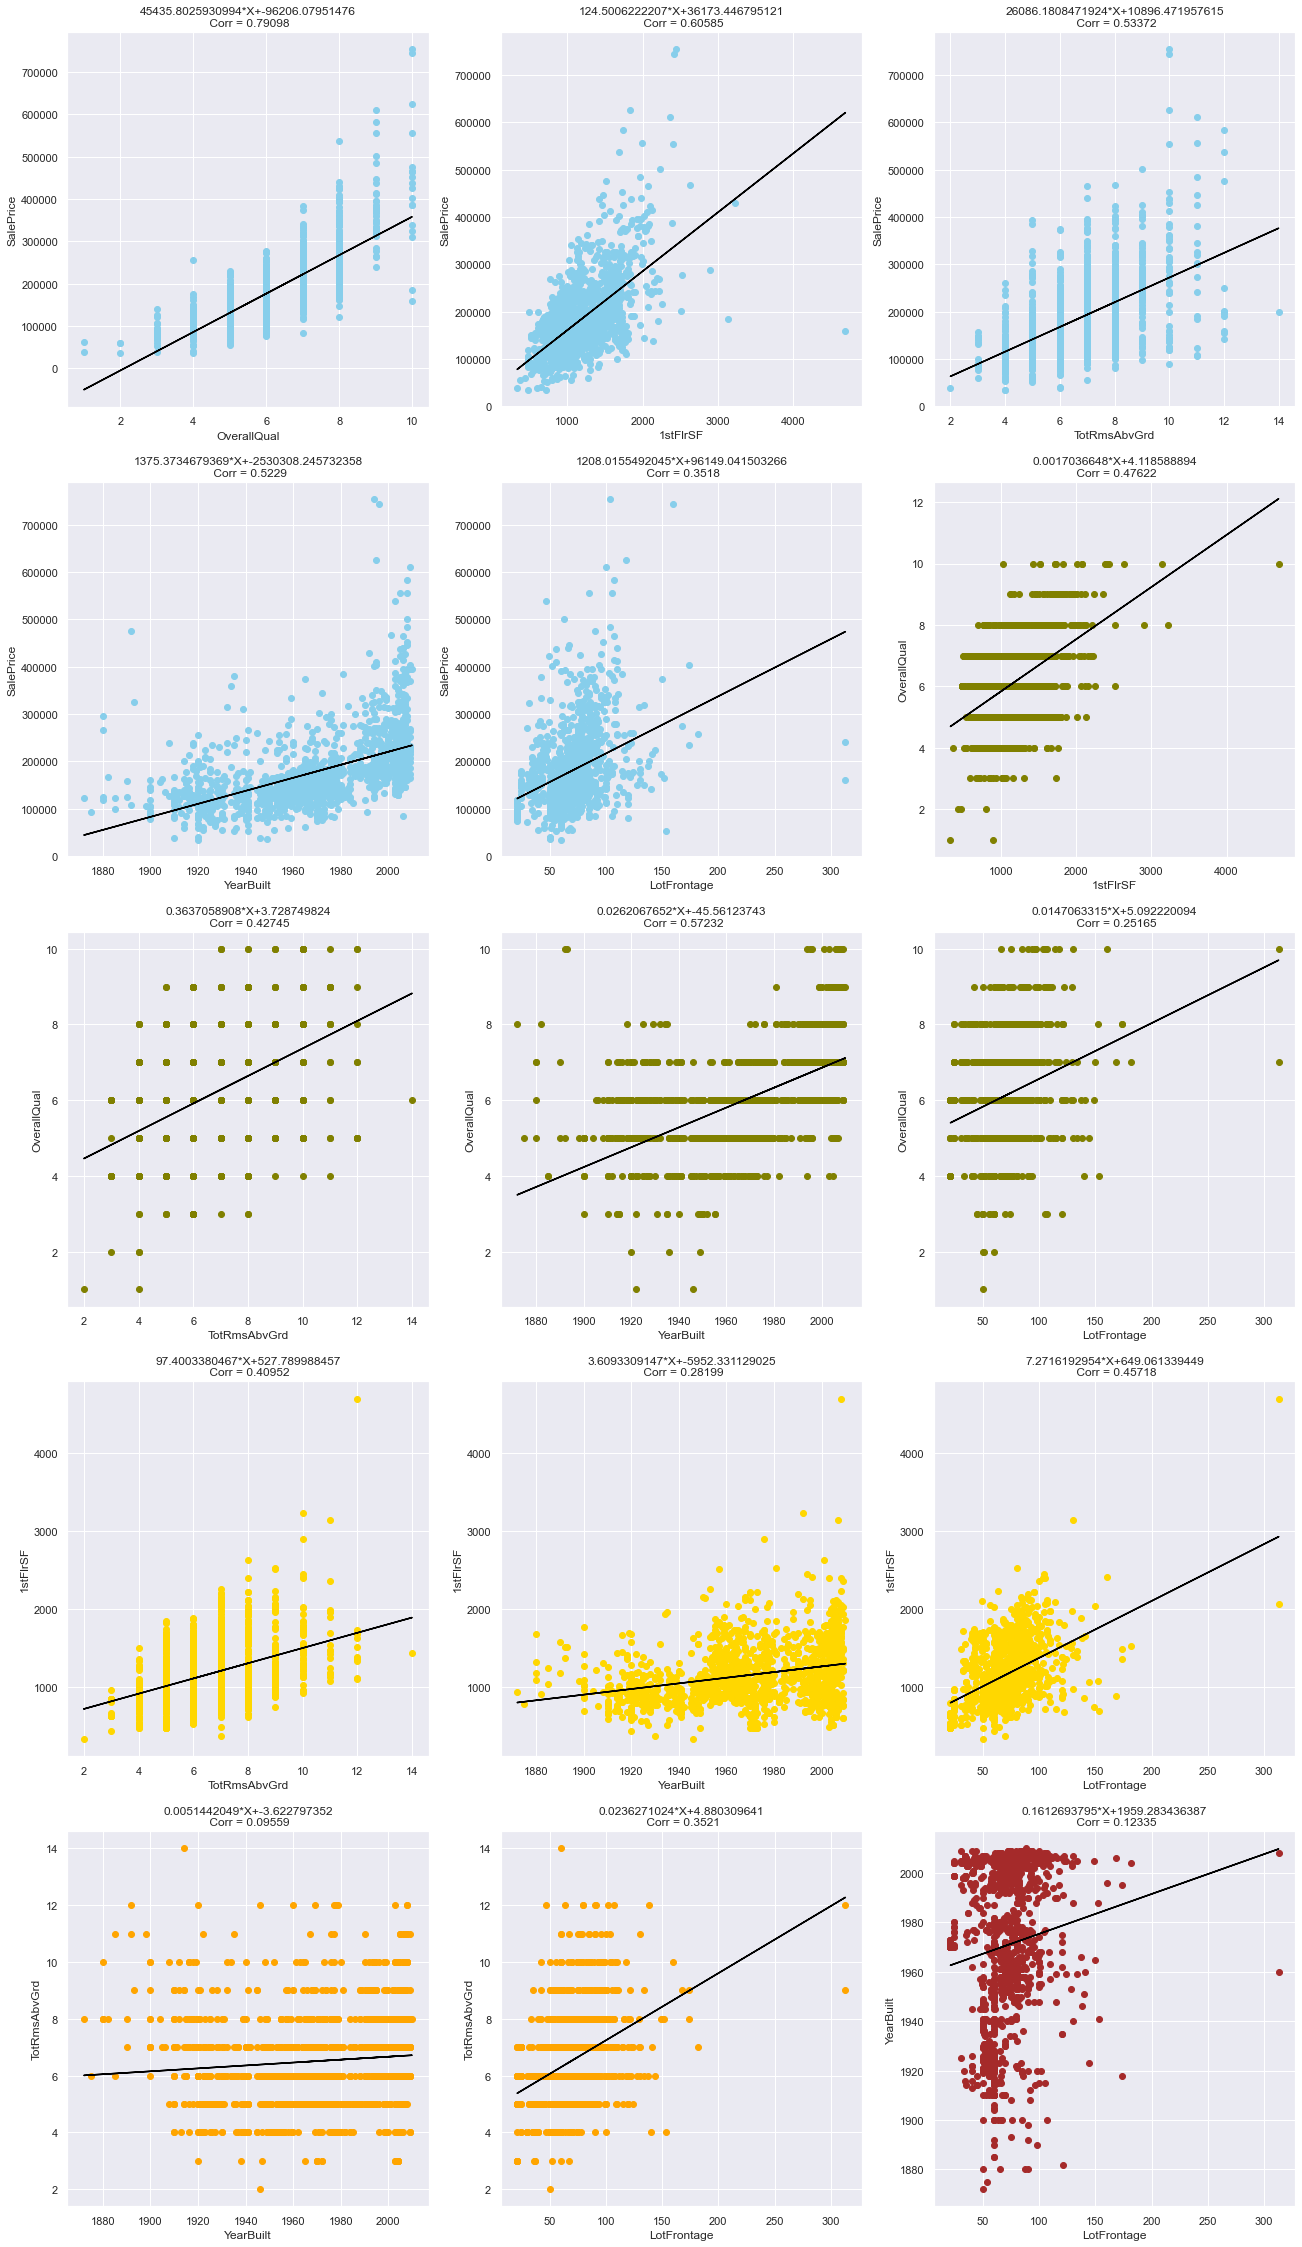

In [7]:
print ("=---------------------------------------------------=")
print ("Graficas las Correlaciones:")
print ("=---------------------------------------------------=")
ModeloUnaVariable.graficarCorrelaciones()

## Funcion para entrenar un modelo de regresion lineal de una variabley = B0+ B1*x.
La funcion recibe como argumentos:
+ Vector con la variable independiente x,
+ Vector con la variable dependiente y,
+ un entero epochs que indica por cuantas iteraciones entrenar el modelo.
+ un entero imprimir error cada , que nos indica cada cuantas iteraciones queremos
+ imprimir a traves de print: el numero de iteracion, el error del modelo en esa iteracion, si imprimir error cada = 10, se despliega en pantalla el error en las iteraciones:
10,20,30,40,50.
+ Escalar (learning rate): es usado como parte de la expresion matematica para actualizar en cada iteracion los parametros del modelo.
+ Agregue el valor inicial de B0 a comenzar
+ Agregue el valor inicial de B1 a comenzar

## Primer modelo con coeficiente de regresion mas alto 

+ Correlacion entre = SalePrice  y  OverallQual = 0.7909816

In [8]:
print ("=---------------------------------------------------=")
print ("Modelo = OverallQual / SalePrice ")
print ("=---------------------------------------------------=")
b0 = 3000
b1 = 200
Mod1 = ModeloUnaVariable.regresionLinealIterado('OverallQual','SalePrice',60000, 10000, 0.001, b0, b1)
print ("=---------------------------------------------------=")
print ("Resultado del modelo:")
print ("=---------------------------------------------------=")
print (Mod1)
print ("=---------------------------------------------------=")

=---------------------------------------------------=
Modelo = OverallQual / SalePrice 
=---------------------------------------------------=
Iteracion:  0  --> Error 15989480976.338184
Iteracion:  10000  --> Error 1242563816.410209
Iteracion:  20000  --> Error 1184019337.500698
Iteracion:  30000  --> Error 1161309067.9180765
Iteracion:  40000  --> Error 1152499418.3298974
Iteracion:  50000  --> Error 1149082024.908645
Iteracion:  60000  --> Error 1147756367.4374008
=---------------------------------------------------=
Resultado del modelo:
=---------------------------------------------------=
            Errores   Coeficiente  Interseccion
0      1.598948e+10   4069.367879    362.087195
1      1.484310e+10   5095.913335    517.488060
2      1.378675e+10   6081.352369    666.470543
3      1.281337e+10   7027.332216    809.291852
4      1.191643e+10   7935.434104    946.198892
...             ...           ...           ...
59996  1.147757e+09  44492.804285 -90582.818328
59997  1.147757

## Crear una funcion que nos permita visualizar con matplotlib como cambia el error en el tiempo: 
+ crear una funcion que tome como parametro el vector de errores generados por la funcion de entrenamiento y grafique en el eje x el numero de iteracion y en el eje y el error para esa iteracion.

=---------------------------------------------------=
Grafica de Error:
=---------------------------------------------------=


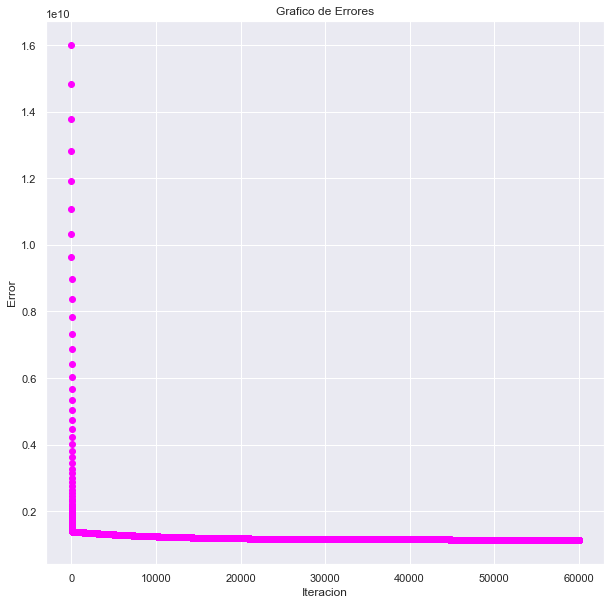

In [9]:
print ("=---------------------------------------------------=")
print ("Grafica de Error:")
print ("=---------------------------------------------------=")
ModelosLineales.graficaErrores(Mod1['Errores'],Mod1.index )

## Crear una funcion que nos permita visualizar con matplotlib como evoluciona el modelo entrenado en el tiempo : 
+ Crear una funcion que tome como parametro la estructura de datos conteniendo el historial de modelos ,y un valor n que indica cada cuantas iteraciones graficar el modelo resultante, por ejemplo para n=3 la funcion debe graficar la recta correspondiente al modelo junto a los datos cada 3 iteraciones, si se ejecutaron 15 iteraciones , para n = 3 se grafica el modelo de las iteraciones 3,6,9,12,15 junto con los datos de entrenamiento.

=---------------------------------------------------=
Grafica de Modelo Iteratico:
=---------------------------------------------------=


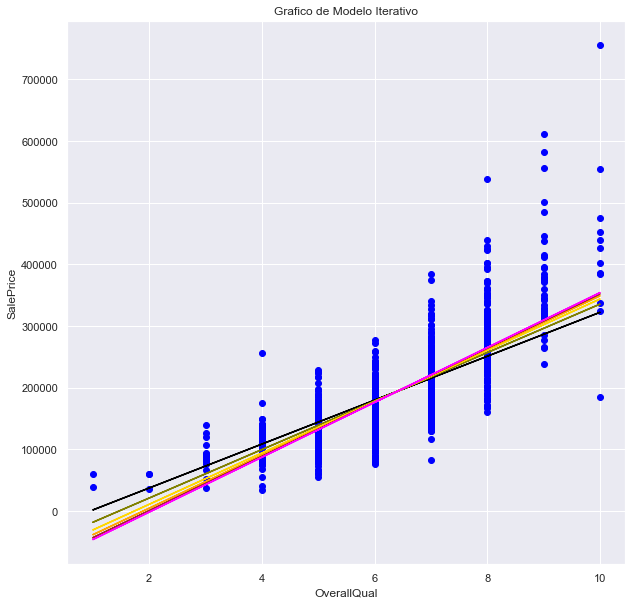

In [10]:
print ("=---------------------------------------------------=")
print ("Grafica de Modelo Iteratico:")
print ("=---------------------------------------------------=")
ModeloUnaVariable.diagramar_modelo_iteracion("SalePrice", "OverallQual", 10000, Mod1)

## Segundo modelo con coeficiente de regresion mas alto 

+ Correlacion entre = SalePrice  y  1stFlrSF = 0.6058522

In [11]:
print ("=---------------------------------------------------=")
print ("Modelo =  1stFlrSF / SalePrice")
print ("=---------------------------------------------------=")
b0 = 5000
b1 = 20000
Mod2 = ModeloUnaVariable.regresionLinealIterado('1stFlrSF','SalePrice',60000, 10000, 0.000001, b0, b1)
print ("=---------------------------------------------------=")
print ("Resultado del modelo:")
print ("=---------------------------------------------------=")
print (Mod2)
print ("=---------------------------------------------------=")

=---------------------------------------------------=
Modelo =  1stFlrSF / SalePrice
=---------------------------------------------------=
Iteracion:  0  --> Error 17455281507554.076
Iteracion:  10000  --> Error 1929661434.1735806
Iteracion:  20000  --> Error 1929651928.4555342
Iteracion:  30000  --> Error 1929642440.6922574
Iteracion:  40000  --> Error 1929632970.8498363
Iteracion:  50000  --> Error 1929623518.894422
Iteracion:  60000  --> Error 1929614084.7922287
=---------------------------------------------------=
Resultado del modelo:
=---------------------------------------------------=
            Errores  Coeficiente  Interseccion
0      1.745528e+13 -2179.547943  19994.378972
1      3.967704e+12  1242.780268  19997.059831
2      9.030381e+11  -388.566230  19995.783368
3      2.066807e+11   389.059768  19996.393271
4      4.845348e+10    18.383032  19996.103986
...             ...          ...           ...
59996  1.929614e+09   137.993235  20054.605419
59997  1.929614e+09   13

## Crear una funcion que nos permita visualizar con matplotlib como cambia el error en el tiempo: 
+ crear una funcion que tome como parametro el vector de errores generados por la funcion de entrenamiento y grafique en el eje x el numero de iteracion y en el eje y el error para esa iteracion.

=---------------------------------------------------=
Grafica de Error:
=---------------------------------------------------=


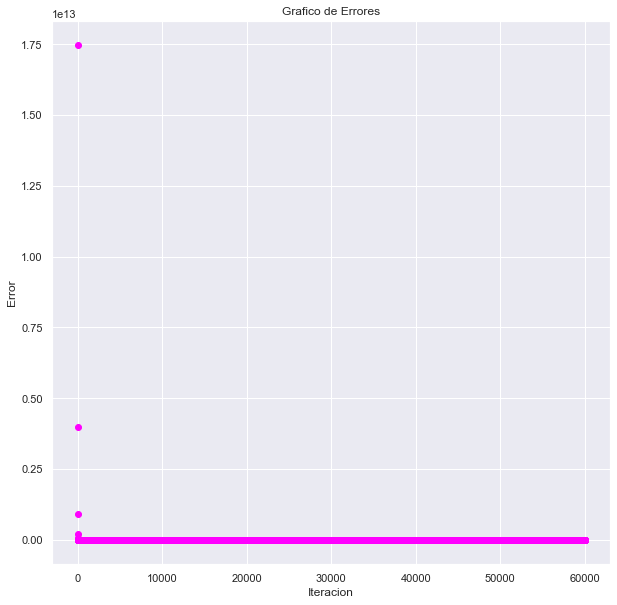

In [12]:
print ("=---------------------------------------------------=")
print ("Grafica de Error:")
print ("=---------------------------------------------------=")
ModelosLineales.graficaErrores(Mod2['Errores'],Mod2.index )

## Crear una funcion que nos permita visualizar con matplotlib como evoluciona el modelo entrenado en el tiempo : 
+ Crear una funcion que tome como parametro la estructura de datos conteniendo el historial de modelos ,y un valor n que indica cada cuantas iteraciones graficar el modelo resultante, por ejemplo para n=3 la funcion debe graficar la recta correspondiente al modelo junto a los datos cada 3 iteraciones, si se ejecutaron 15 iteraciones , para n = 3 se grafica el modelo de las iteraciones 3,6,9,12,15 junto con los datos de entrenamiento.

=---------------------------------------------------=
Grafica de Modelo Iteratico:
=---------------------------------------------------=


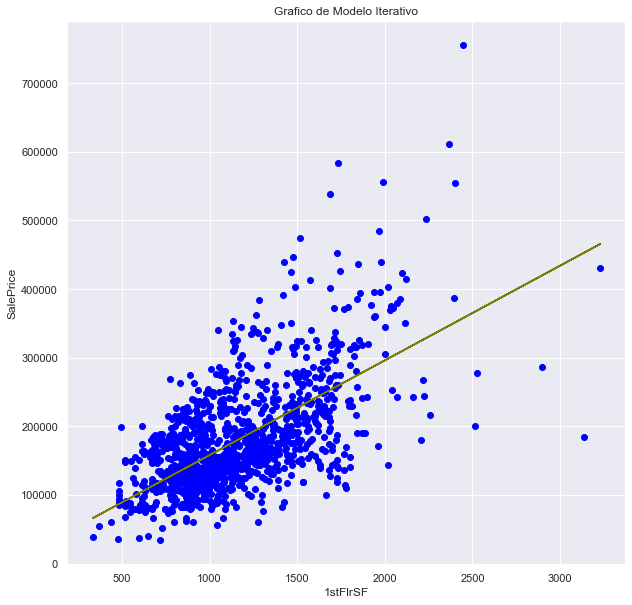

In [13]:
print ("=---------------------------------------------------=")
print ("Grafica de Modelo Iteratico:")
print ("=---------------------------------------------------=")
ModeloUnaVariable.diagramar_modelo_iteracion("SalePrice", "1stFlrSF", 30000, Mod2)

## Para cada una de las variables x seleccionadas, usar scikit-learn para entrenar un modelo de regresion lineal:

Para cada variable independiente x elegida, crear una funcion que usando el modelo entrenado manualmente y el modelo de scikit-learn (enviados como parametros a la funcion) calcule la estimacion o prediccion de cada uno de estos y devuelva como resultado una prediccion estimada promediando las predicciones de los 2 modelos, la funcion debe recibir como parametro adicional un vector de cualquier tamanio de x y devolver 3 vectores cada uno del mismo tamanio del vector x, estos vectores son:
+ La prediccion con el modelo entrenado manualmente
+ La prediccion con el modelo de scikit-learn
+ La combinacion(promedio) de las 2 anteriores.

In [14]:
from sklearn.metrics import mean_squared_error


DataCompletaSK = np.load('./proyecto_data/proyecto_training_data.npy')
particion = pd.DataFrame(DataCompletaSK, columns=['SalePrice','OverallQual','1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage'])
filas = int(len(particion)*(80/100)) # calculo el 80%
ModeloSK = particion[:filas] # Hago la particion del modelo
ValidacionSK = particion[filas:]

+ Modelo de regresion lineal entre SalePrice y OverallQual

In [15]:
# Creando modelo lineal 
#Training
y = pd.DataFrame(ModeloSK['SalePrice']).values
x = pd.DataFrame(ModeloSK['OverallQual']).values
#Evaluacion
y_test = pd.DataFrame(ValidacionSK['SalePrice']).values
x_test = pd.DataFrame(ValidacionSK['OverallQual']).values

modeloLineal1 = linear_model.LinearRegression()
modeloLineal1.fit(x,y)
predicciony1 = modeloLineal1.predict(x_test)
### print regression parameters
print ("=-----------------SalePrice y OverallQual----------------------=")
print('Coeficiente:', modeloLineal1.coef_)
print('Interseccion:', modeloLineal1.intercept_)
print('R**2:',modeloLineal1.score(x,y))
print("mean_squared_error:",mean_squared_error(y_test, predicciony1))
print ("mean_squared_error Manual:",((((y_test-predicciony1)**2)/(len(y_test))).sum()))
print ("=--------------------------------------------------------------=")

=-----------------SalePrice y OverallQual----------------------=
Coeficiente: [[45411.99877916]]
Interseccion: [-96469.57131874]
R**2: 0.6304202002336672
mean_squared_error: 2630182608.9486394
mean_squared_error Manual: 2630182608.948639
=--------------------------------------------------------------=


+ Modelo de regresion lineal entre SalePrice y 1stFlrSF

In [16]:
# Creando modelo lineal 
#Training
y = pd.DataFrame(ModeloSK['SalePrice']).values
x = pd.DataFrame(ModeloSK['1stFlrSF']).values
#Evaluacion
y_test = pd.DataFrame(ValidacionSK['SalePrice']).values
x_test = pd.DataFrame(ValidacionSK['1stFlrSF']).values

modeloLineal2 = linear_model.LinearRegression()
modeloLineal2.fit(x,y)
predicciony2 = modeloLineal2.predict(x_test)
### print regression parameters
print ("=-----------------SalePrice y 1stFlrSF ------------------------=")
print('Coeficiente:', modeloLineal2.coef_)
print('Interseccion:', modeloLineal2.intercept_)
print('R**2:',modeloLineal2.score(x,y))
print("mean_squared_error:",mean_squared_error(y_test, predicciony2))
print ("mean_squared_error Manual:",((((y_test-predicciony2)**2)/(len(x_test))).sum()))
print ("=--------------------------------------------------------------=")

=-----------------SalePrice y 1stFlrSF ------------------------=
Coeficiente: [[129.95124229]]
Interseccion: [30324.58517496]
R**2: 0.37981176187078936
mean_squared_error: 4585538274.6918745
mean_squared_error Manual: 4585538274.6918745
=--------------------------------------------------------------=


Para cada variable independiente x elegida, crear una funcion que usando el modelo entrenado manualmente y el modelo de scikit-learn(enviados como parametros a la funcion) calcule la estimacion o prediccion de cada uno de estos y devuelva como
resultado una prediccion estimada promediando las predicciones de los 2 modelos, la funcion debe recibir como parametro adicional un vector de cualquier tamanio de X y devolver 3 vectores cada uno del mismo tamanio del vector x, estos vectores son:
+ La prediccion con el modelo entrenado manualmente
+ La prediccion con el modelo de scikit-learn
+ La combinacion(promedio) de las 2 anteriores.

In [18]:
#Evaluacion
y_test = pd.DataFrame(ValidacionSK['SalePrice']).values
x_test = pd.DataFrame(ValidacionSK['OverallQual']).values
#Datos a Evaluar
print ("=---------------------------------------------------=")
print ("Comparativa de modelos: SalePrice y OverallQual")
print ("=---------------------------------------------------=")
modelosTotales1 = ModelosLineales.comparativa_modelos(Mod1, modeloLineal1,x_test)
print ("=--------------Modelos-------------------------------=")
modelosTotales1

=---------------------------------------------------=
Comparativa de modelos: SalePrice y OverallQual
=---------------------------------------------------=
Coeficiente SKILEARN: [[45411.99877916]]
Interseccion SKILEARN: [-96469.57131874]
Coeficiente Iterativo: 44492.97835795189
Interseccion Iterativo: -90583.93313714223
Coeficiente Promediado: [[44952.48856856]]
Interseccion Iterativo: [-93526.75222794]
=--------------Modelos-------------------------------=


,Itrativo,ScikitLearn,Promediado
0,176373.937011,176002.421356,176188.179183
1,354345.850442,357650.416473,355998.133458
2,176373.937011,176002.421356,176188.179183
3,176373.937011,176002.421356,176188.179183
4,220866.915369,221414.420135,221140.667752
...,...,...,...
287,176373.937011,176002.421356,176188.179183
288,176373.937011,176002.421356,176188.179183
289,220866.915369,221414.420135,221140.667752
290,131880.958653,130590.422577,131235.690615


In [19]:
#Evaluacion
y = pd.DataFrame(ModeloSK['SalePrice']).values
x = pd.DataFrame(ModeloSK['1stFlrSF']).values
#Datos a Evaluar
print ("=---------------------------------------------------=")
print ("Comparativa de modelos: SalePrice y 1stFlrSF")
print ("=---------------------------------------------------=")
modelosTotales2 = ModelosLineales.comparativa_modelos(Mod2, modeloLineal2,x_test)
print ("=--------------Modelos-------------------------------=")
modelosTotales2

=---------------------------------------------------=
Comparativa de modelos: SalePrice y 1stFlrSF
=---------------------------------------------------=
Coeficiente SKILEARN: [[129.95124229]]
Interseccion SKILEARN: [30324.58517496]
Coeficiente Iterativo: 137.9932315954929
Interseccion Iterativo: 20054.609302706045
Coeficiente Promediado: [[133.97223694]]
Interseccion Iterativo: [25189.59723883]
=--------------Modelos-------------------------------=


,Itrativo,ScikitLearn,Promediado
0,20882.568692,31104.292629,25993.430660
1,21434.541619,31624.097598,26529.319608
2,20882.568692,31104.292629,25993.430660
3,20882.568692,31104.292629,25993.430660
4,21020.561924,31234.243871,26127.402897
...,...,...,...
287,20882.568692,31104.292629,25993.430660
288,20882.568692,31104.292629,25993.430660
289,21020.561924,31234.243871,26127.402897
290,20744.575461,30974.341386,25859.458424


Usando el 20% de los datos de validacion, aplicamos los modelos predictivos para estimar la variable dependiente y usando los valores reales de Y calculamos el error de cada modelo. Para cada variable independiente X elegida:
+ Grafcar el error de cada modelo para esta variable X
+ Concluir cual modelo para la variable x es el mejor a ser usado (error mas bajo)

=-----------------------------------------------------------=
Comparativa de Error en modelos: SalePrice y OverallQual
=-----------------------------------------------------------=
=---------- De Menor Error a Mayor Error -------------------=
                      MSE
ScikitLearn  2.630183e+09
Promediado   2.630255e+09
Itrativo     2.631199e+09


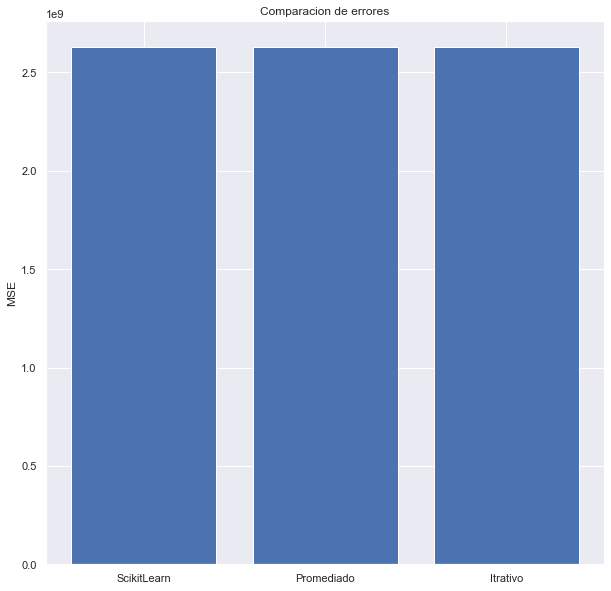

In [20]:
#Evaluacion
y_test = pd.DataFrame(ValidacionSK['SalePrice']).values
x_test = pd.DataFrame(ValidacionSK['OverallQual']).values
#Datos a Evaluar
print ("=-----------------------------------------------------------=")
print ("Comparativa de Error en modelos: SalePrice y OverallQual")
print ("=-----------------------------------------------------------=")
print ("=---------- De Menor Error a Mayor Error -------------------=")
ModelosLineales.comparativa_Errores(modelosTotales1,y_test)

=-----------------------------------------------------------=
Comparativa de Error en modelos: SalePrice y OverallQual
=-----------------------------------------------------------=
=---------- De Menor Error a Mayor Error -------------------=
                      MSE
ScikitLearn  2.952196e+10
Promediado   3.109204e+10
Itrativo     3.271436e+10


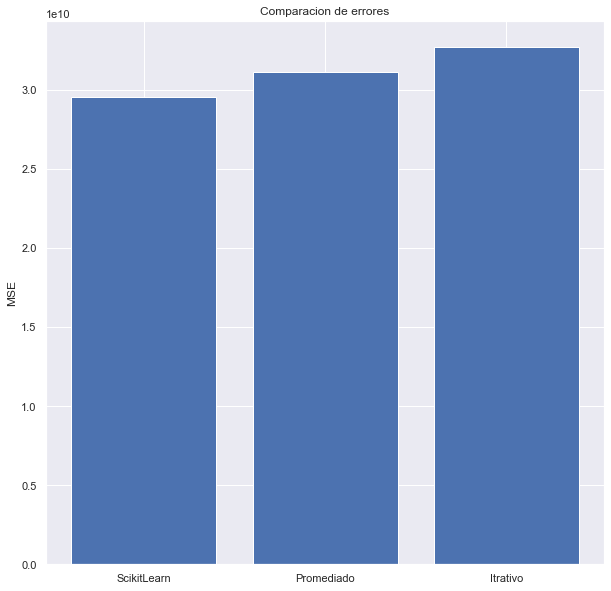

In [21]:
#Evaluacion
y_test = pd.DataFrame(ValidacionSK['SalePrice']).values
x_test = pd.DataFrame(ValidacionSK['1stFlrSF']).values
#Datos a Evaluar
print ("=-----------------------------------------------------------=")
print ("Comparativa de Error en modelos: SalePrice y OverallQual")
print ("=-----------------------------------------------------------=")
print ("=---------- De Menor Error a Mayor Error -------------------=")
ModelosLineales.comparativa_Errores(modelosTotales2,y_test)